In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [29]:
import sys
sys.path.insert(0,'drive/data_NPZ')

import os 
import glob
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2


from sklearn.model_selection import train_test_split

def load_data_training_and_test(path):
    
    npzfile = np.load(path + "2class_all_training_data.npz")
    train = npzfile['arr_0']
    
    npzfile = np.load(path + "2class_all_training_label.npz")
    train_labels = npzfile['arr_0']
    
    train_set, test_set = train_test_split(train,test_size=0.3,random_state=0)
    train_label,test_label=train_test_split(train_labels,test_size=0.3,random_state=0)

    return (train_set,train_label),(test_set,test_label)



path='drive/data_NPZ/alex-net/'

(x_train, y_train), (x_test, y_test) = load_data_training_and_test(path)




# Reshaping our label data from (2000,) to (2000,1) and test data from (1000,) to (1000,1)

# Reshaping our label data from (2000,) to (2000,1) and test data from (1000,) to (1000,1)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Change our image type to float32 data type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize our data by changing the range from (0 to 255) to (0 to 1)
x_train /= 255
x_test /= 255

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)




from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_test = mlb.fit_transform(y_test)

mlb2=MultiLabelBinarizer()
y_train=mlb2.fit_transform(y_train)

num_classes = y_test.shape[1]
print("Number of class:"+str(num_classes))

from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=5,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    rescale=1./255)

datagen.fit(x_train)
test_datagen.fit(x_test)

num_classes = y_test.shape[1]
print("NUmber Of class:"+str(num_classes))



(1122, 227, 227, 3)
(1122, 1)
(481, 227, 227, 3)
(481, 1)
Number of class:2
NUmber Of class:2


In [30]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D



batch_size=32
epochs = 40

input_shape = (227, 227, 3)


model = Sequential()


model.add(Conv2D(96,(11,11),activation="relu",input_shape=input_shape,strides=(4,4),padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='valid'))


# 2nd Convolutional Layer

model.add(Conv2D(256,kernel_size=(11,11),activation="relu",strides=(1,1), padding='valid'))

model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

#model.add(Dropout(0.25))



model.add(Conv2D(384,(3,3),activation="relu",padding="valid",strides=(1,1)))

model.add(Conv2D(384,(3,3),activation="relu",padding="valid",strides=(1,1)))


model.add(Conv2D(256,(3,3),activation="relu",padding="valid",strides=(1,1)))

model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))


      #↨ Fully connencted Layer

model.add(Flatten())

model.add(Dense(4096))
model.add(Activation("relu"))#kernel_initializer='random_normal'

model.add(Dropout(0.4))


model.add(Dense(4096))
model.add(Activation("relu"))#kernel_initializer='random_normal'
model.add(Dropout(0.4))

model.add(Dense(1000))
model.add(Activation("relu"))#kernel_initializer='random_normal'
model.add(Dropout(0.4))


model.add(Dense(num_classes))#kernel_initializer='random_normal'
model.add(Activation("softmax"))

model.summary()



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 6, 6, 384)         885120    
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 4, 4, 384)         1327488   
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 2, 2, 256)        

In [28]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping



from keras.optimizers import SGD,Adam,RMSprop,Adadelta,Adagrad,Adamax
opt = Adam()

#opt = Adam(lr= 0.001,decay=1e-6)
#opt=keras.optimizers.rmsprop(lr=1,decay=1e-6)
#opt=keras.optimizers.adam(lr=1)


model.compile(loss='binary_crossentropy', #2 class (not multiple class)
              optimizer=opt,
              metrics=['accuracy'])


early_stop=EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')

#print(model.summary())



weight_name="drive/best_weights_for_AlexNet_2class.hdf5"
checkpointer = ModelCheckpoint(filepath=weight_name, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

#validation_steps = 50 or len(x_test)
#validation_data = test_datagen.flow(x_test,y_test)
#steps_per_epoch = 118, shuffle=true

#validation_data=(x_test, y_test)
#history=model.fit_generator(datagen.flow(x_train,y_train,batch_size=64),callbacks=[checkpointer,early_stop],validation_data = test_datagen.flow(x_test,y_test)
                           # ,epochs=40)

history=model.fit(x_train,y_train,batch_size=64,callbacks=[checkpointer,early_stop],validation_data=(x_test, y_test),epochs=40)

model.save("drive/AlexNet_3class_Adam_with_AUG.h5")



import matplotlib.pyplot as plt
# Plot Accuracy
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 1122 samples, validate on 481 samples
Epoch 1/40
1122/1122 [==============================] - 6s 5ms/step - loss: 0.6595 - accuracy: 0.8030 - val_loss: 0.4657 - val_accuracy: 0.8358

Epoch 00001: val_accuracy improved from -inf to 0.83576, saving model to drive/best_weights_for_AlexNet_2class.hdf5
Epoch 2/40
1122/1122 [==============================] - 3s 3ms/step - loss: 0.5132 - accuracy: 0.8369 - val_loss: 0.4698 - val_accuracy: 0.8358

Epoch 00002: val_accuracy did not improve from 0.83576
Epoch 3/40
1122/1122 [==============================] - 3s 3ms/step - loss: 0.4592 - accuracy: 0.8369 - val_loss: 0.4350 - val_accuracy: 0.8358

Epoch 00003: val_accuracy did not improve from 0.83576
Epoch 4/40
1122/1122 [==============================] - 3s 3ms/step - loss: 0.4376 - accuracy: 0.8369 - val_loss: 0.4385 - val_accuracy: 0.8358

Epoch 00004: val_accuracy did not improve from 0.83576
Epoch 5/40
1122/1122 [==============================] - 3s 3ms/step - loss: 0.4633 - accurac

KeyboardInterrupt: ignored

In [26]:
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


model.load_weights(weight_name)

y_predicted =  model.predict_classes(x_test)
#print(y_predicted)

#print(y_test)

y_true = np.argmax(y_test, axis=1)
#print(y_true)


from sklearn.metrics import confusion_matrix


classes=['covid', 'normal']


cm=confusion_matrix(y_true, y_predicted,labels=[0,1])

print(cm)
print("\n")





#plot confusion matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(cm, classes)


from sklearn.metrics import classification_report


print(classification_report(y_true, y_predicted))

ValueError: ignored

No handles with labels found to put in legend.


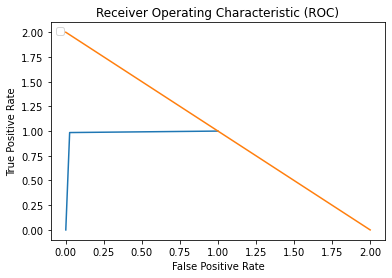

In [22]:
#Roc curve
from sklearn.metrics import roc_curve



import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# y-expected output ve ypred_prediction

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_predicted)
roc_auc=auc(fpr_keras,tpr_keras)

plt.figure()
plt.plot(fpr_keras, tpr_keras,thresholds_keras)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")

plt.legend(loc='upper left')

plt.show()
